# 3 Inhibitory Neuron Classes Sine Wave Task Evolution Engine


In [94]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
from snntorch import functional
from snntorch import LIF
from snntorch import spikeplot as splt


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from copy import deepcopy

### Sine Wave Dataset

In [96]:
# Sine Wave Task Version: Explicit Time Resetting with period 
class SineWaveDatasetLocal(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.num_timesteps = 100 # length of sine wave sequence

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        amplitude = self.data.iloc[idx, 0]
        sine_wave = eval(self.data.iloc[idx, 1])  
        
        # L1: Explicit Time Resetting with period 
        amplitude_vector = torch.tensor([amplitude] * self.num_timesteps, dtype=torch.float32)
        time_vector = torch.tensor([i for i in range(40)] * (self.num_timesteps//int(40)+1), dtype=torch.float32)
        time_vector = time_vector[:self.num_timesteps]
        sine_wave_vector = torch.tensor(sine_wave, dtype=torch.float32)
        
        input_vector = torch.stack([amplitude_vector,time_vector],dim=1)  # Shape: [num_timesteps, 2]
        target_vector = torch.stack([sine_wave_vector],dim=1)
        return input_vector, sine_wave_vector

# Load the datasets
dataset0 = SineWaveDatasetLocal('train_data_sine_2.csv')
dataloader0 = DataLoader(dataset0, batch_size=25, shuffle=True)

### Building Connectivity and Neurons

In [97]:
# creates a connection matrix with the specified sparseness for linear layers
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx


# creates an excitatory and inhibitory matrix for reccurent layer
def hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn):
    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Excitatory connections

    # excitatory to excitatory
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-p_nn['e_e'], p_nn['e_e']])
    # excitatory to inhibitory PV
    weight_matrix[:num_excitatory, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, 1], size=(num_excitatory, num_iPV), p=[1-p_nn['e_PV'], p_nn['e_PV']])
    # excitatory to inhibitory Sst
    weight_matrix[:num_excitatory, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, 1], size=(num_excitatory, num_iSst), p=[1-p_nn['e_Sst'], p_nn['e_Sst']])
    # excitatory to inhibitory Htr
    weight_matrix[:num_excitatory, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, 1], size=(num_excitatory, num_iHtr), p=[1-p_nn['e_Htr'], p_nn['e_Htr']])


    # Inhibitory connections

    # inhibitory PV to excitatory
    weight_matrix[num_excitatory:num_excitatory+num_iPV, :num_excitatory] = np.random.choice([0, -1], size=(num_iPV, num_excitatory), p=[1-p_nn['PV_e'], p_nn['PV_e']])
    # inhibitory PV to inhibitory PV
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iPV, num_iPV), p=[1-p_nn['PV_PV'], p_nn['PV_PV']])
    # inhibitory PV to inhibitory Htr
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iPV, num_iSst), p=[1-p_nn['PV_Sst'], p_nn['PV_Sst']])
    # inhibitory PV to inhibitory Sst
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iPV, num_iHtr), p=[1-p_nn['PV_Htr'], p_nn['PV_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, :num_excitatory] = np.random.choice([0, -1], size=(num_iSst, num_excitatory), p=[1-p_nn['Sst_e'], p_nn['Sst_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iSst, num_iPV), p=[1-p_nn['Sst_PV'], p_nn['Sst_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iSst, num_iSst), p=[1-p_nn['Sst_Sst'], p_nn['Sst_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iSst, num_iHtr), p=[1-p_nn['Sst_Htr'], p_nn['Sst_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV+num_iSst:, :num_excitatory] = np.random.choice([0, -1], size=(num_iHtr, num_excitatory), p=[1-p_nn['Htr_e'], p_nn['Htr_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iHtr, num_iPV), p=[1-p_nn['Htr_PV'], p_nn['Htr_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iHtr, num_iSst), p=[1-p_nn['Htr_Sst'], p_nn['Htr_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iHtr, num_iHtr), p=[1-p_nn['Htr_Htr'], p_nn['Htr_Htr']]) 


    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

In [98]:
# leaky integrate-and-fire neuron with recurrent connections from snn torch with refractory period

class RLIF1(LIF):
    def __init__(
        self,
        beta,
        V=1.0,
        all_to_all=True,
        linear_features=None,
        conv2d_channels=None,
        kernel_size=None,
        threshold=-55.0,  # Changed threshold to -55 mV
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        learn_recurrent=True,
        reset_mechanism="zero",
        state_quant=False,
        output=False,
        reset_delay=True,
        refractory_period=5, # Refractory period of 5 timesteps
    ):
        super().__init__(
            beta,
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_beta,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
        )

        self.all_to_all = all_to_all
        self.learn_recurrent = learn_recurrent

        # linear params
        self.linear_features = linear_features

        # Conv2d params
        self.kernel_size = kernel_size
        self.conv2d_channels = conv2d_channels

        # catch cases
        self._rleaky_init_cases()

        # initialize recurrent connections
        if self.all_to_all:
            self._init_recurrent_net()
        else:
            self._V_register_buffer(V, learn_recurrent)
            self._init_recurrent_one_to_one()

        if not learn_recurrent:
            self._disable_recurrent_grad()

        self._init_mem()

        if self.reset_mechanism_val == 0:
            self.state_function = self._base_sub
        elif self.reset_mechanism_val == 1:
            self.state_function = self._base_zero
        elif self.reset_mechanism_val == 2:
            self.state_function = self._base_int

        self.reset_delay = reset_delay

        # Refractory period in timesteps
        self.refractory_period = refractory_period

    def _init_mem(self):
        spk = torch.zeros(0)
        mem = torch.zeros(0)
        refractory_counter = torch.zeros(0)

        self.register_buffer("spk", spk, False)
        self.register_buffer("mem", mem, False)
        self.register_buffer("refractory_counter", refractory_counter, persistent=False)

    def reset_mem(self):
        self.spk = torch.zeros_like(self.spk, device=self.spk.device)
        # Initialize the membrane potential with a normal distribution (mean=0, std=1)
        self.mem = torch.randn_like(self.mem, device=self.mem.device)
        self.refractory_counter = torch.zeros_like(self.refractory_counter, device=self.refractory_counter.device)
        return self.spk, self.mem

    def init_rleaky(self):
        return self.reset_mem()

    def forward(self, input_, spk=None, mem=None, refractory_counter=None):
        if not spk is None:
            self.spk = spk

        if not mem is None:
            self.mem = mem

        if not refractory_counter is None:
            self.refractory_counter = refractory_counter

        if self.init_hidden and (not mem is None or not spk is None or not refractory_counter is None):
            raise TypeError(
                "When `init_hidden=True`, RLeaky expects 1 input argument."
            )

        if not self.spk.shape == input_.shape:
            self.spk = torch.zeros_like(input_, device=self.spk.device)

        if not self.mem.shape == input_.shape:
            self.mem = torch.randn_like(input_, device=self.mem.device)

        if not self.refractory_counter.shape == input_.shape:
            self.refractory_counter = torch.zeros_like(input_, device=self.refractory_counter.device)

        # With each forward, decrement the counter
        self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)

        # Update the membrane potential
        self.reset = self.mem_reset(self.mem)
        self.mem = self.state_function(input_)

        # Set a spike on when refractory period is 0
        refractory_mask = (self.refractory_counter == 0)
        self.spk = self.fire(self.mem) * refractory_mask

        # Update the refractory counter back to 5 where spikes occurred
        self.refractory_counter[self.spk > 0] = self.refractory_period

        if not self.reset_delay:
            do_reset = (
                self.spk / self.graded_spikes_factor - self.reset
            )
            if self.reset_mechanism_val == 0:
                self.mem = self.mem - do_reset * self.threshold
            elif self.reset_mechanism_val == 1:
                self.mem = self.mem - do_reset * self.mem

        if self.output:
            return self.spk, self.mem
        elif self.init_hidden:
            return self.spk
        else:
            return self.spk, self.mem

    def _init_recurrent_net(self):
        if self.all_to_all:
            if self.linear_features:
                self._init_recurrent_linear()
            elif self.kernel_size is not None:
                self._init_recurrent_conv2d()
        else:
            self._init_recurrent_one_to_one()

    def _init_recurrent_linear(self):
        self.recurrent = nn.Linear(self.linear_features, self.linear_features)

    def _init_recurrent_conv2d(self):
        self._init_padding()
        self.recurrent = nn.Conv2d(
            in_channels=self.conv2d_channels,
            out_channels=self.conv2d_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
        )

    def _init_padding(self):
        if type(self.kernel_size) is int:
            self.padding = self.kernel_size // 2, self.kernel_size // 2
        else:
            self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2

    def _init_recurrent_one_to_one(self):
        self.recurrent = RecurrentOneToOne(self.V)

    def _disable_recurrent_grad(self):
        for param in self.recurrent.parameters():
            param.requires_grad = False

    def _base_state_function(self, input_):
        # Adjusting beta to decay towards -70 mV
        base_fn = (
            self.beta.clamp(0, 1) * (self.mem + 70) + input_ + self.recurrent(self.spk) - 70
        )
        return base_fn

    def _base_sub(self, input_):
        return self._base_state_function(input_) - self.reset * self.threshold

    def _base_zero(self, input_):
        return self._base_state_function(input_) - self.reset * self._base_state_function(input_)

    def _base_int(self, input_):
        return self._base_state_function(input_)

    def _rleaky_init_cases(self):
        all_to_all_bool = bool(self.all_to_all)
        linear_features_bool = self.linear_features
        conv2d_channels_bool = bool(self.conv2d_channels)
        kernel_size_bool = bool(self.kernel_size)

        if all_to_all_bool:
            if not (linear_features_bool):
                if not (conv2d_channels_bool or kernel_size_bool):
                    raise TypeError(
                        "When `all_to_all=True`, RLeaky requires either"
                        "`linear_features` or (`conv2d_channels` and "
                        "`kernel_size`) to be specified. The "
                        "shape should match the shape of the output spike of "
                        "the layer."
                    )
                elif conv2d_channels_bool ^ kernel_size_bool:
                    raise TypeError(
                        "`conv2d_channels` and `kernel_size` must both be"
                        "specified. The shape of `conv2d_channels` should "
                        "match the shape of the output"
                        "spikes."
                    )
            elif (linear_features_bool and kernel_size_bool) or (
                linear_features_bool and conv2d_channels_bool
            ):
                raise TypeError(
                    "`linear_features` cannot be specified at the same time as"
                    "`conv2d_channels` or `kernel_size`. A linear layer and "
                    "conv2d layer cannot both"
                    "be specified at the same time."
                )
        else:
            if (
                linear_features_bool
                or conv2d_channels_bool
                or kernel_size_bool
            ):
                raise TypeError(
                    "When `all_to_all`=False, none of `linear_features`,"
                    "`conv2d_channels`, or `kernel_size` should be specified. "
                    "The weight `V` is used"
                    "instead."
                )

    @classmethod
    def detach_hidden(cls):
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                cls.instances[layer].mem.detach_()
                cls.instances[layer].spk.detach_()

    @classmethod
    def reset_hidden(cls):
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                (
                    cls.instances[layer].spk,
                    cls.instances[layer].mem,
                ) = cls.instances

### Defining the Network

In [ ]:
# RSNN model with 2 input neurons, 200 hidden neurons, and 1 output neuron, with 3 inhibitory neuron classes
class RSNN2(nn.Module):
    def __init__(self):
        super(RSNN2, self).__init__()
        num_inputs = 2
        num_hidden = 200
        num_output = 1
        pe_e = 0.16

        # Dictionary with probabilities of connection between each neuron type 
        p_nn = {'e_e': 0.16, 'e_PV': 0.395, 'e_Sst': 0.182, 'e_Htr': 0.105,
                'PV_e': 0.411, 'PV_PV': 0.451, 'PV_Sst': 0.03, 'PV_Htr': 0.22,
                'Sst_e': 0.424, 'Sst_PV': 0.857, 'Sst_Sst': 0.082, 'Sst_Htr': 0.77,
                'Htr_e': 0.087, 'Htr_PV': 0.02, 'Htr_Sst': 0.0625, 'Htr_Htr': 0.028
                } 

        self.p_nn = p_nn
        
        # Define the dimensions
        num_excitatory = round(0.85 * num_hidden) # 85% : 15% Excitatory to inhibitory
        self.num_excitatory = num_excitatory
        num_inhibitory = num_hidden - num_excitatory

        # Three inhibitory neuron classes: 40% PV, 30% Sst, 30% Ht3aR
        num_iPV = round(0.4 * num_inhibitory)
        self.num_iPV = num_iPV
        num_iSst = round(0.3 * num_inhibitory)
        self.num_iSst = num_iSst
        num_iHtr = num_inhibitory - num_iSst - num_iPV
        self.num_iHtr = num_iHtr

        # Three beta values for E, PV, Sst, and Htr3aR
        # Values chosen based on spike triggered adaptation behavior of each class
        beta_e = torch.asarray([0.85] * num_excitatory)
        beta_iPV = torch.asarray([0.7] * num_iPV)   # Little/ no spike frequency adaptation 
        beta_iHtr = torch.asarray([0.6] * num_iHtr)    # Mostly adapting
        beta_iSst = torch.asarray([0.3] * num_iSst)  # Spike frequency adaptation
        beta = torch.cat((beta_e, beta_iPV, beta_iSst, beta_iHtr)) # create array of betas corresponding to each neuron!

        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn) 
        self.rlif1 = RLIF1(reset_mechanism='zero', threshold = 1, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        #hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.l2.weight.data = hid_out_mx.T 

    def forward(self, inputs):
        spk1,mem1 = self.rlif1.init_rleaky()
        self.spk1_rec = []
        self.cur2_rec = []

        # print(inputs.shape)
        for step in range(inputs.shape[0]): #300
            cur_input = inputs[step,:]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            self.mem1 = mem1
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec)
        self.cur2_rec = torch.stack(self.cur2_rec)
        
        return self.cur2_rec, self.spk1_rec

    def positive_negative_weights(self):

        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg)
        self.false_pos.append(num_false_pos)

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51


        #change the code so that for any vanishing excitatory neuron, populate another excitatory.

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values


In [ ]:
# Custom Loss Function， only factor in the MSE loss and the firing rate loss

class CustomLoss(nn.Module):

    def __init__(self, target_firing_rate=0.02, batch_size=25):
        super(CustomLoss, self).__init__()
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)
    

    def forward(self, outputs, targets, firing_rate):

        # adjustable weighting factors for MSE loss and firing rate loss
        w_rate = 1
        w_mse = 1
        
        mse_loss = nn.MSELoss()(outputs.squeeze(), targets)
        rate_loss = nn.MSELoss()(firing_rate, self.target_firing_rate)
 
        self.mse_loss = mse_loss
        self.rate_loss = rate_loss

        total_loss = w_mse*mse_loss + w_rate*rate_loss 

        return total_loss

### Evolution

In [ ]:
# Genetic Encoding and Decoding

# converts model to gene format by concatenating all the parameters
def encode_model(model):
    gene = []
    for param in model.parameters():
        gene.append(param.data.cpu().numpy().flatten())
    gene = np.concatenate(gene)
    return gene

# decodes gene to model format by reshaping the gene to the original parameter shapes
def decode_model(model, gene):
    current_index = 0
    new_model = deepcopy(model)
    for param in new_model.parameters():
        param_shape = param.data.cpu().numpy().shape
        param_size = np.prod(param_shape)
        param.data = torch.tensor(gene[current_index:current_index + param_size].reshape(param_shape))
        current_index += param_size
    return new_model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Generation 1/10, Best Fitness: 343.0452880859375
Overall Best Fitness: 343.0452880859375
Generation 2/10, Best Fitness: 355.0911560058594
Overall Best Fitness: 343.0452880859375
Generation 3/10, Best Fitness: 377.42742919921875
Overall Best Fitness: 343.0452880859375
Generation 4/10, Best Fitness: 326.41693115234375
Overall Best Fitness: 326.41693115234375
Generation 5/10, Best Fitness: 381.130615234375
Overall Best Fitness: 326.41693115234375
Generation 6/10, Best Fitness: 349.02447509765625
Overall Best Fitness: 326.41693115234375
Generation 7/10, Best Fitness: 322.195068359375
Overall Best Fitness: 322.195068359375
Generation 8/10, Best Fitness: 358.75396728515625
Overall Best Fitness: 322.195068359375
Generation 9/10, Best Fitness: 342.90185546875
Overall Best Fitness: 322.195068359375
Generation 10/10, Best Fitness: 352.5256042480469
Overall Best Fitness: 322.195068359375


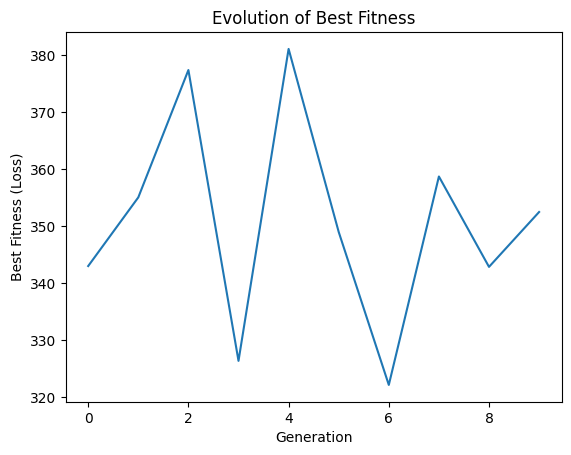

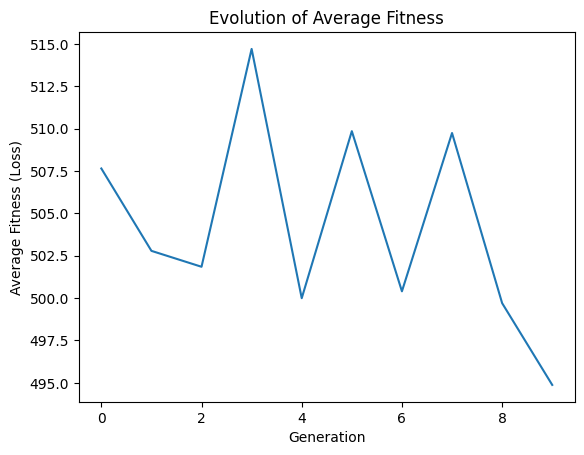

In [ ]:
# Main Evolution Class

class Evolution(object):
    def __init__(self, model_class, model_args, model_kwargs):
        # Initialize the model class and its arguments
        self.model_class = model_class
        self.model_args = model_args
        self.model_kwargs = model_kwargs


    # initialize first population of models 
    def populate(self, n_models):
        models = []
        for _ in range(n_models):
            model = self.model_class(*self.model_args, **self.model_kwargs)
            self.initialize_weights(model)
            # Freeze the weights
            for param in model.parameters():
                param.requires_grad = False
            models.append(model)
        return models

    # initialize weights of the model with specified three inhibitory neuron classes
    def initialize_weights(self, model):
        num_excitatory = model.num_excitatory
        num_hidden = model.l1.out_features
        num_iPV = model.num_iPV
        num_iSst = model.num_iSst
        num_iHtr = model.num_iHtr
        num_inputs = model.l1.in_features
        num_output = model.l2.out_features
        p_nn = model.p_nn
        num_inhibitory = num_hidden - num_excitatory
        pe_e = 0.16

        # Initialize the input to hidden layer weights
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        model.l1.weight.data = input_hid_mx.T

        # Initialize the recurrent layer weights
        hidden_mx = hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn)
        model.rlif1.recurrent.weight.data = hidden_mx.T

        # Initialize the hidden to output layer weights
        hid_out_mx = conn_mx(num_hidden, num_output, pe_e)
        model.l2.weight.data = hid_out_mx.T

        # Store the initial sparsity mask
        self.weights = model.rlif1.recurrent.weight.data
        self.sparse_mask = torch.where(self.weights == 0, 1, 0)
    
    # encode the population of models to gene representation
    def encode_population(self, models):
        return [encode_model(model) for model in models]
    
    # decode the population of genes to model representation
    def decode_population(self, genes, template_model):
        return [decode_model(template_model, gene) for gene in genes]

    # evaluate the models in the population
    def evaluate(self, models, dataloader):
        fitness = []
        for model in models:
            loss = self.evaluate_model(model, dataloader)
            fitness.append(loss)
        return fitness

    # evaluate the model with the sine wave dataloader
    def evaluate_model(self, model, dataloader):
        criterion = CustomLoss(target_firing_rate=0.02)
        running_loss = 0

        model.eval()
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(dataloader):
                outputs, spikes = model(inputs)
                firing_rate = torch.sum(spikes) / torch.tensor(spikes.numel(), dtype=torch.float)
                loss = criterion(outputs, targets, firing_rate)
                running_loss += loss.item()
                break
        return running_loss

    # select the top k models based on fitness
    def select(self, genes, fitness, k=2):
        selected_indices = np.argsort(fitness)[:k]
        return [genes[i] for i in selected_indices], [fitness[i] for i in selected_indices]

    # crossover the parents to generate offspring
    def crossover(self, parent1, parent2):
        child = deepcopy(parent1)
        crossover_mask = np.random.rand(len(child)) < 0.5
        child[crossover_mask] = parent2[crossover_mask]
        return child

    # mutate the gene with a mutation rate
    def mutate(self, gene, mutation_rate):
        mutation_mask = np.random.rand(len(gene)) < mutation_rate
        gene[mutation_mask] += np.random.randn(np.sum(mutation_mask))

        # Decode the gene to model format
        model = self.model_class(*self.model_args, **self.model_kwargs)
        decode_model(model, gene)  # Assuming decode_model is a method of the class

        # Reapply the initial sparsity mask to inforce sparsity
        model_weights = model.rlif1.recurrent.weight.data
        model_weights[self.sparse_mask == True] = 0

        # Split the weights into excitatory and inhibitory
        excitatory_weights = model_weights[:, :model.num_excitatory]
        inhibitory_weights = model_weights[:, model.num_excitatory:]

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        # Ensure no neuron vanishes to enforce dale's law
        self.handle_vanishing_neurons(model, excitatory_weights, inhibitory_weights)  # Assuming handle_vanishing_neurons is a method of the class

        return gene
    
    # dale's law
    def handle_vanishing_neurons(self, model, excitatory_weights, inhibitory_weights):
        num_excitatory = model.num_excitatory

        mu = -0.64
        sigma = 0.51

        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        excitatory_zero_indices = (model.rlif1.recurrent.weight.data[:, :num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (model.rlif1.recurrent.weight.data[:, num_excitatory:] == 0).nonzero(as_tuple=True)

        if len(excitatory_zero_indices[0]) > num_false_pos:
            excitatory_sampled_indices = torch.stack([
                excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
            ], dim=1)

            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            model.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if len(inhibitory_zero_indices[0]) > num_false_neg:
            inhibitory_sampled_indices = torch.stack([
                inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
            ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            model.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values


    # generate next population of offspring from parents
    def generate_offspring(self, parents, n_offspring, mutation_rate):
        offspring = []
        for _ in range(n_offspring):
            parent1, parent2 = random.sample(parents, 2)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child, mutation_rate)
            offspring.append(child)
        return offspring

    # plot the most fit model's fitness across generations
    def plot_best_fitness(self, all_best_fitness):
        plt.figure()
        plt.plot(all_best_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness (Loss)")
        plt.title("Evolution of Best Fitness")
        plt.show()

    # plot the distribution of fitness across generations as a histogram
    def plot_fitness_distribution(self, all_fitness):
        plt.figure()
        num_generations = len(all_fitness)
        cmap = plt.get_cmap("viridis", num_generations)  # Use the viridis colormap

        for i, fitness in enumerate(all_fitness):
            plt.hist(fitness, bins=30, alpha=0.5, label=f'Gen {i+1}', color=cmap(i / num_generations))

        norm = plt.Normalize(vmin=1, vmax=num_generations)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ticks=np.linspace(1, num_generations, num_generations))
        cbar.set_label('Generation')

        plt.xlabel("Fitness (Loss)")
        plt.ylabel("Frequency")
        plt.title("Fitness Distribution Across Generations")
        plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
        plt.show()


    # plot the average fitness across generations
    def plot_average_fitness(self, all_fitness):
        average_fitness = [np.mean(fitness) for fitness in all_fitness]
        plt.figure()
        plt.plot(average_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Average Fitness (Loss)")
        plt.title("Evolution of Average Fitness")
        plt.show()

    # run the evolutionary process
    def evolve(self, n_models, n_offspring, n_generations, dataloader, mutation_rate):
        template_model = self.model_class(*self.model_args, **self.model_kwargs)
        # intialize first population of models
        models = self.populate(n_models)
        initial_models = deepcopy(models)
        genes = self.encode_population(models)
        all_genes = []
        all_best_fitness = []
        all_fitness = []
        best_gene_overall = None
        best_fitness_overall = float('inf')
        
        # run the evolution process for n_generations
        for i in range(n_generations):
            all_genes.append(genes)
            models = self.decode_population(genes, template_model)
            fitness = self.evaluate(models, dataloader)
            all_fitness.append(fitness)
            parents, parent_fitness = self.select(genes, fitness)
            offspring = self.generate_offspring(parents, n_offspring, mutation_rate)
            genes = parents + offspring
            best_fitness = min(parent_fitness)
            all_best_fitness.append(best_fitness)

            if best_fitness < best_fitness_overall:
                best_fitness_overall = best_fitness
                best_gene_overall = deepcopy(parents[0])
                
            print(f"Generation {i+1}/{n_generations}, Best Fitness: {best_fitness}")
            print(f"Overall Best Fitness: {best_fitness_overall}")


        self.plot_best_fitness(all_best_fitness)
        self.plot_average_fitness(all_fitness)
        self.plot_fitness_distribution(all_fitness)

        best_model = self.decode_population([best_gene_overall], template_model)[0]
        final_population = self.decode_population(genes, template_model)
    
        # np.savez_compressed('evolution_data.npz',
        #                     all_genes=all_genes,
        #                     all_best_fitness=all_best_fitness,
        #                     all_fitness=all_fitness,
        #                     best_gene_overall=best_gene_overall,
        #                     best_fitness_overall=best_fitness_overall
        #                     initial_models=initial_models
        #                     final_population=final_population
        #                     best_model=best_model)

        return best_model, all_best_fitness, final_population, initial_models


In [ ]:
# Define the parameters for the evolutionary process
pop_size = 100
num_generations = 10
n_offspring = 100
mutation_rate = 0.05

# Create the evolution object and run the evolution process
evolution = Evolution(RSNN2, (), {})
best_model, fitness, final_population, initial_models = evolution.evolve(pop_size, n_offspring, num_generations, dataloader0, mutation_rate)

# Save the best model's state dictionary
torch.save(best_model.state_dict(), "best_model.pth")

### Plotting 

In [ ]:
# Generates raster plot of the spiking activity of the model
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    spk_tensor = spk_tensor.T
    fig, axs = plt.subplots(figsize=(10, 5))

    # Plot spikes
    splt.raster(spk_tensor, axs, s=0.5, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    axs.set_xlabel("Timestep")
    axs.set_ylabel("Neuron")
    axs.set_title(title)

    plt.show()

/var/folders/8p/mfl5cdcn0997x08q9rnq16t80000gn/T/ipykernel_1570/2630802330.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Backprop', 'Evolution'])
/var/folders/8p/mfl5cdcn0997x08q9rnq16t80000gn/T/ipykernel_1570/2630802330.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Backprop', 'Evolution'])
/var/folders/8p/mfl5cdcn0997x08q9rnq16t80000gn/T/ipykernel_1570/2630802330.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(['Backprop', 'Evolution'])


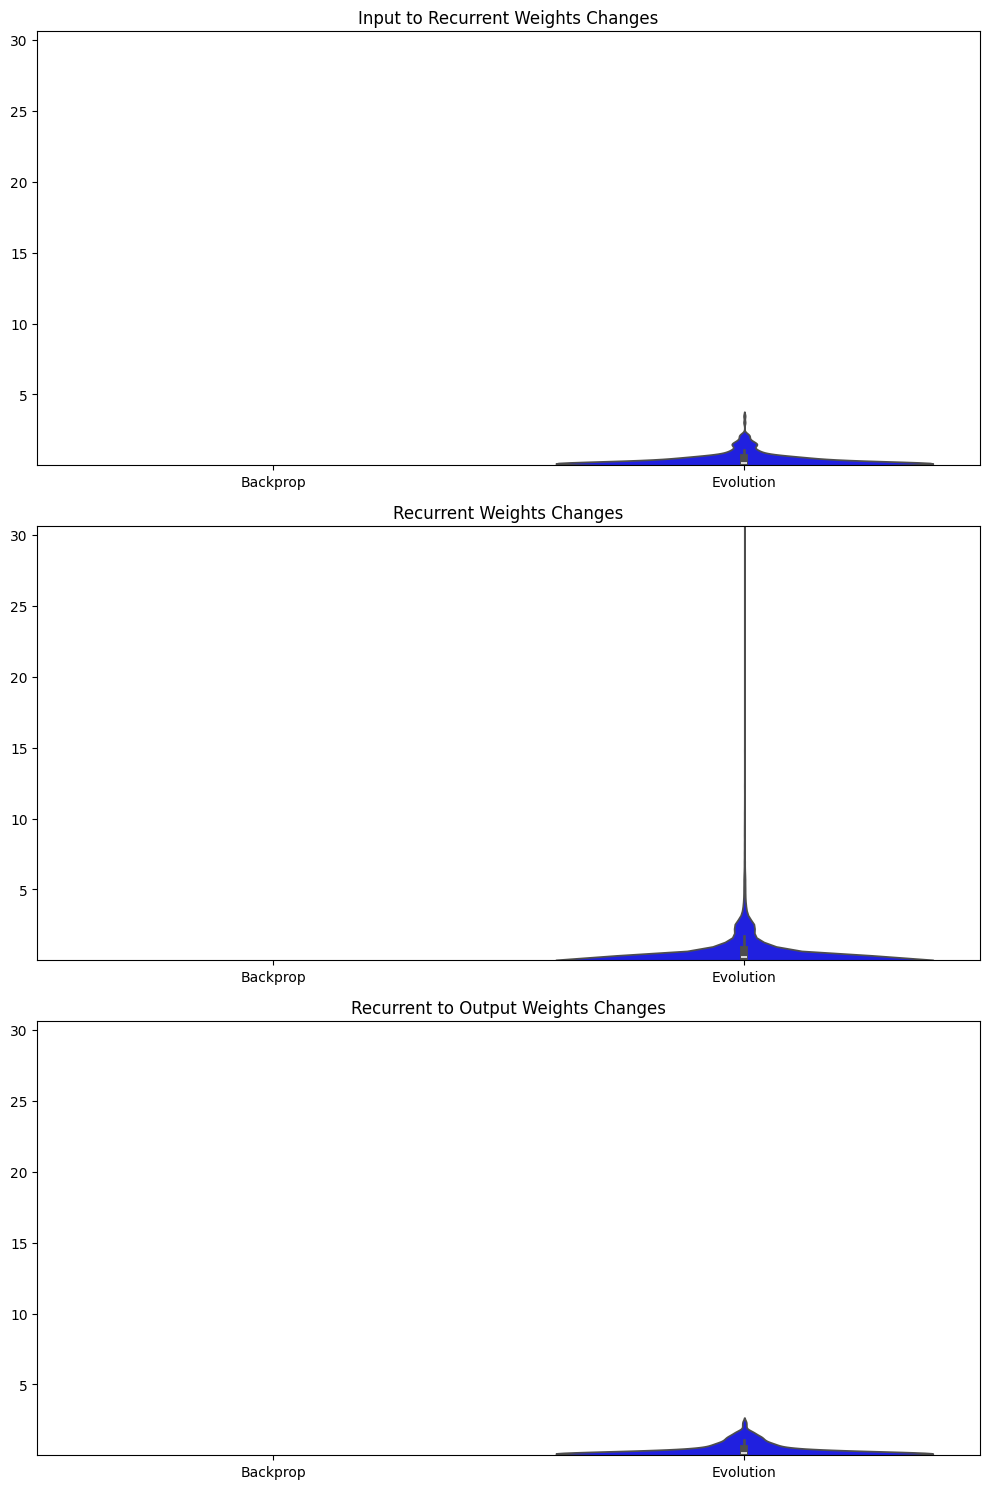

In [ ]:
# to generate violin plots of the weight changes between the initial and final weights of the models

# extracts weight changes from the models
def get_layer_weights(models):
    layer_weights = {
        'input_recurrent': [],
        'recurrent': [],
        'recurrent_output': []
    }
    
    for model in models:
        input_recurrent_weights = model.l1.weight.data.cpu().numpy()
        recurrent_weights = model.rlif1.recurrent.weight.data.cpu().numpy()
        recurrent_output_weights = model.l2.weight.data.cpu().numpy()
        
        layer_weights['input_recurrent'].append(input_recurrent_weights)
        layer_weights['recurrent'].append(recurrent_weights)
        layer_weights['recurrent_output'].append(recurrent_output_weights)
    
    avg_weights = {
        'input_recurrent': np.mean(layer_weights['input_recurrent'], axis=0),
        'recurrent': np.mean(layer_weights['recurrent'], axis=0),
        'recurrent_output': np.mean(layer_weights['recurrent_output'], axis=0)
    }
    
    return layer_weights, avg_weights


# computes the absolute differences between the initial and final weights
def compute_weight_differences(initial_weights, final_weights):
    weight_diffs = {}

    for layer in initial_weights.keys():
        # Compute absolute differences
        differences = np.abs(final_weights[layer] - initial_weights[layer])
        
        # Filter out weight changes that are zero
        non_zero_differences = differences[differences != 0]
        
        weight_diffs[layer] = non_zero_differences

    return weight_diffs


# generates violin plots for backprop and evolution weight changes
def plot_violin_plots(weight_changes_backprop, weight_changes_evolution):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Combine all data to find the global min and max
    all_data = np.concatenate([
        weight_changes_backprop['input_recurrent'],
        weight_changes_evolution['input_recurrent'],
        weight_changes_backprop['recurrent'],
        weight_changes_evolution['recurrent'],
        weight_changes_backprop['recurrent_output'],
        weight_changes_evolution['recurrent_output']
    ])
    y_min = np.min(all_data)
    y_max = np.max(all_data)

    # Input to Recurrent Weights
    sns.violinplot(data=[weight_changes_backprop['input_recurrent'], weight_changes_evolution['input_recurrent']],
                   ax=axs[0], palette=['red', 'blue'])
    axs[0].set_title('Input to Recurrent Weights Changes')
    axs[0].set_xticklabels(['Backprop', 'Evolution'])
    axs[0].set_ylim(y_min, y_max)

    # Recurrent Weights
    sns.violinplot(data=[weight_changes_backprop['recurrent'], weight_changes_evolution['recurrent']],
                   ax=axs[1], palette=['red', 'blue'])
    axs[1].set_title('Recurrent Weights Changes')
    axs[1].set_xticklabels(['Backprop', 'Evolution'])
    axs[1].set_ylim(y_min, y_max)

    # Recurrent to Output Weights
    sns.violinplot(data=[weight_changes_backprop['recurrent_output'], weight_changes_evolution['recurrent_output']],
                   ax=axs[2], palette=['red', 'blue'])
    axs[2].set_title('Recurrent to Output Weights Changes')
    axs[2].set_xticklabels(['Backprop', 'Evolution'])
    axs[2].set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

In [ ]:
# loads the best evolution model and the final backprop model
backprop_model = RSNN2()
backprop_model.load_state_dict(torch.load('results/final_backprop_model.pth'))
backprop_model.eval()  # Set the model to evaluation mode

# Encode and decode the best model to get the best performing model in a list
best_perf = evolution.decode_population(evolution.encode_population([best_model]), best_model)

# Get initial and final weights
initial_weights_backprop, avg_initial_weights_backprop = get_layer_weights([backprop_model])
final_weights_backprop, avg_final_weights_backprop = get_layer_weights([backprop_model])

initial_weights_evolution, avg_initial_weights_evolution = get_layer_weights(initial_models)
final_weights_evolution, avg_final_weights_evolution = get_layer_weights(final_population)

# Compute weight differences
weight_changes_backprop = compute_weight_differences(avg_initial_weights_backprop, avg_final_weights_backprop)
weight_changes_evolution = compute_weight_differences(avg_initial_weights_evolution, avg_final_weights_evolution)

# Plot violin plots
plot_violin_plots(weight_changes_backprop, weight_changes_evolution)

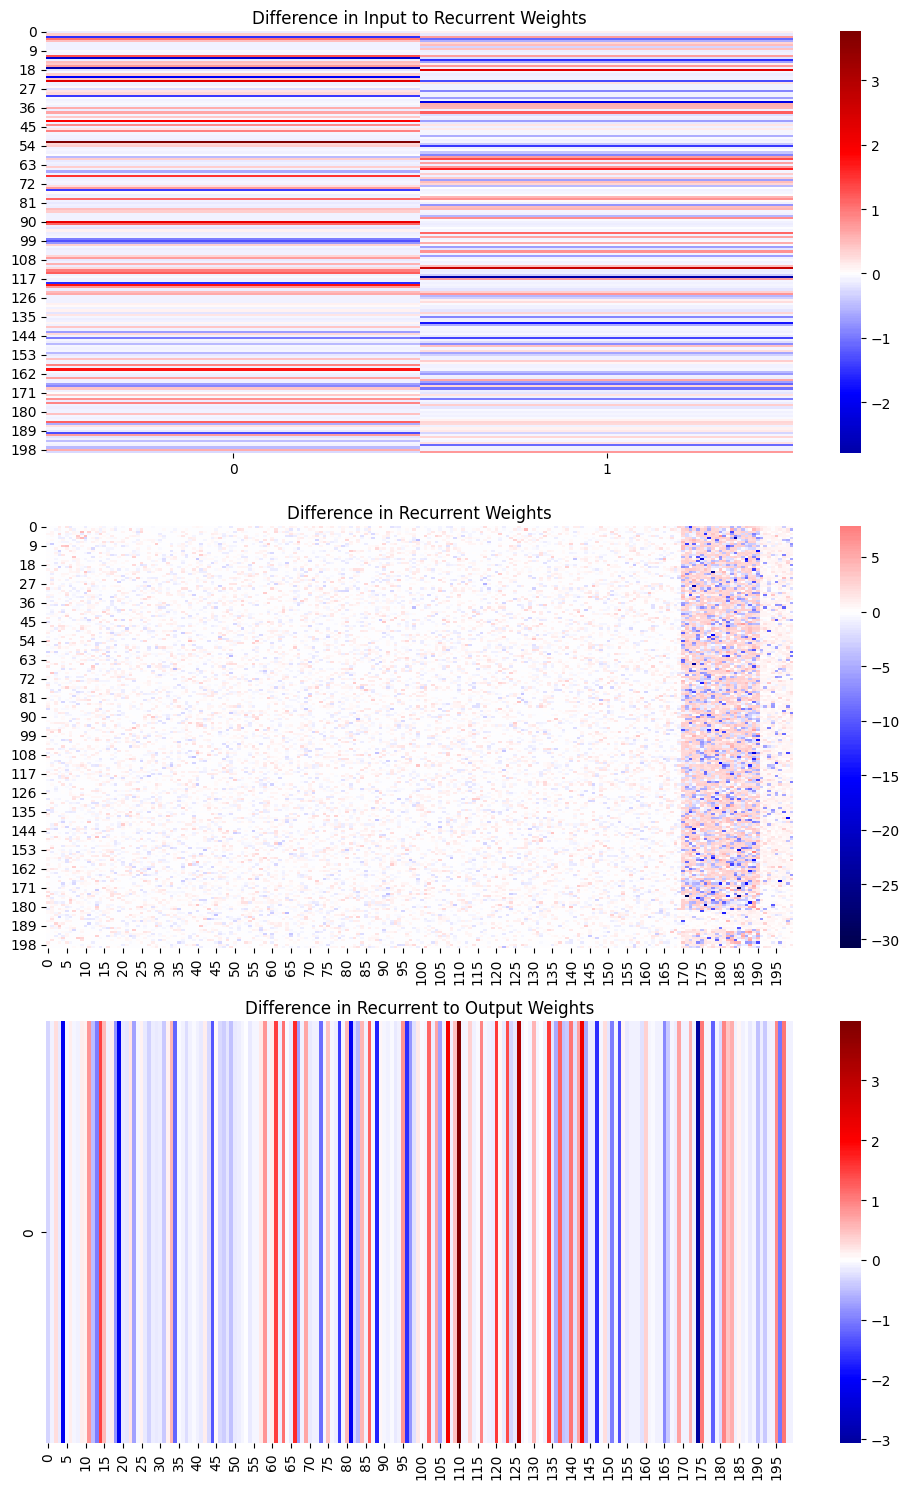

In [ ]:
# generates heatmaps to capture the connectivity changes between the initial and final models
def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot heatmaps for each layer
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    sns.heatmap(weight_diffs['input_recurrent'], ax=axs[0], cmap="seismic", center=0 )
    axs[0].set_title('Difference in Input to Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent'], ax=axs[1], cmap="seismic", center=0)
    axs[1].set_title('Difference in Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent_output'], ax=axs[2], cmap="seismic", center=0)
    axs[2].set_title('Difference in Recurrent to Output Weights')
    
    plt.tight_layout()
    plt.show()

def get_layer_weights(models):
    layer_weights = {
        'input_recurrent': [],
        'recurrent': [],
        'recurrent_output': []
    }
    
    for model in models:
        input_recurrent_weights = model.l1.weight.data.cpu().numpy()
        recurrent_weights = model.rlif1.recurrent.weight.data.cpu().numpy()
        recurrent_output_weights = model.l2.weight.data.cpu().numpy()
        
        layer_weights['input_recurrent'].append(input_recurrent_weights)
        layer_weights['recurrent'].append(recurrent_weights)
        layer_weights['recurrent_output'].append(recurrent_output_weights)
    
    avg_weights = {
        'input_recurrent': np.mean(layer_weights['input_recurrent'], axis=0),
        'recurrent': np.mean(layer_weights['recurrent'], axis=0),
        'recurrent_output': np.mean(layer_weights['recurrent_output'], axis=0)
    }
    
    return avg_weights

# Usage example after evolution process
initial_models = evolution.populate(pop_size)
best_perf = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, final_population)


In [ ]:
# generates line plots to capture the connectivity changes between the initial and final models
def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot the differences for each layer
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    
    # Input to recurrent layer weights differences
    axs[0].plot(weight_diffs['input_recurrent'].flatten(), label='Weight Differences')
    axs[0].set_title('Difference in Input to Recurrent Weights')
    axs[0].set_xlabel('Weight Index')
    axs[0].set_ylabel('Weight Difference')
    axs[0].legend()
    
    # Recurrent layer weights differences
    axs[1].plot(weight_diffs['recurrent'].flatten(), label='Weight Differences')
    axs[1].set_title('Difference in Recurrent Weights')
    axs[1].set_xlabel('Weight Index')
    axs[1].set_ylabel('Weight Difference')
    axs[1].legend()
    
    # Recurrent to output layer weights differences
    axs[2].plot(weight_diffs['recurrent_output'].flatten(), label='Weight Differences')
    axs[2].set_title('Difference in Recurrent to Output Weights')
    axs[2].set_xlabel('Weight Index')
    axs[2].set_ylabel('Weight Difference')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

def get_layer_weights(models):
    layer_weights = {
        'input_recurrent': [],
        'recurrent': [],
        'recurrent_output': []
    }
    
    for model in models:
        input_recurrent_weights = model.l1.weight.data.cpu().numpy()
        recurrent_weights = model.rlif1.recurrent.weight.data.cpu().numpy()
        recurrent_output_weights = model.l2.weight.data.cpu().numpy()
        
        layer_weights['input_recurrent'].append(input_recurrent_weights)
        layer_weights['recurrent'].append(recurrent_weights)
        layer_weights['recurrent_output'].append(recurrent_output_weights)
    
    avg_weights = {
        'input_recurrent': np.mean(layer_weights['input_recurrent'], axis=0),
        'recurrent': np.mean(layer_weights['recurrent'], axis=0),
        'recurrent_output': np.mean(layer_weights['recurrent_output'], axis=0)
    }
    
    return avg_weights

# Usage example after evolution process
final_models = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, final_models)

ValueError: operands could not be broadcast together with shapes (200,2) (100,2) 

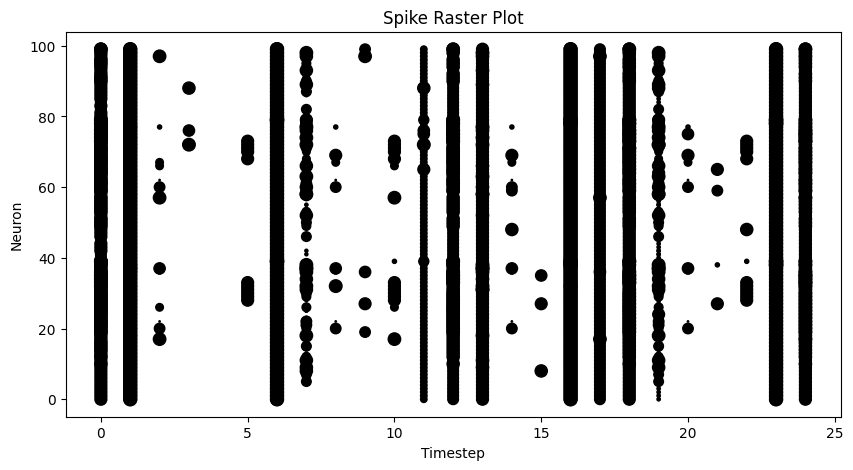

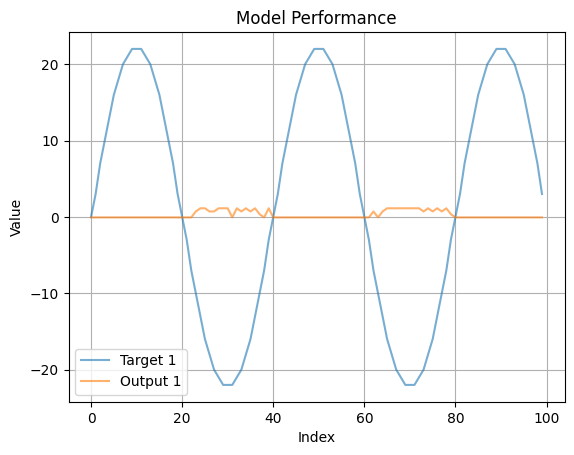

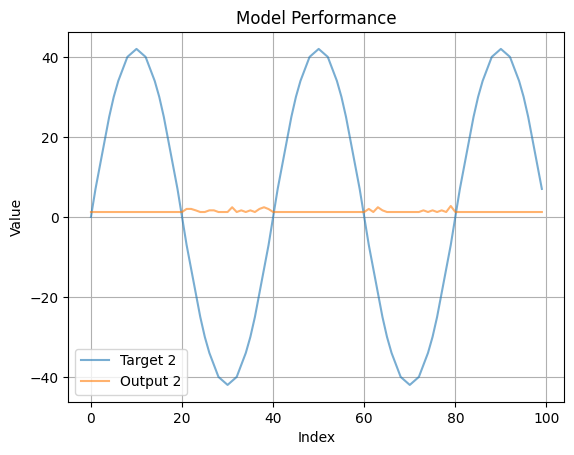

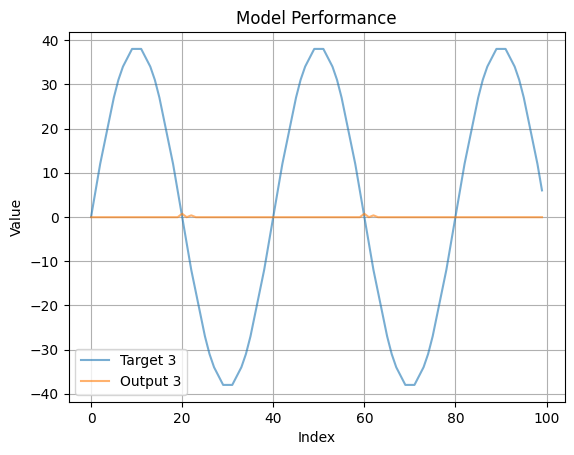

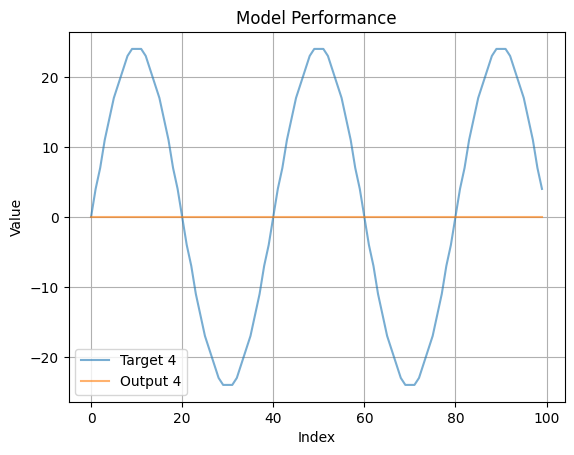

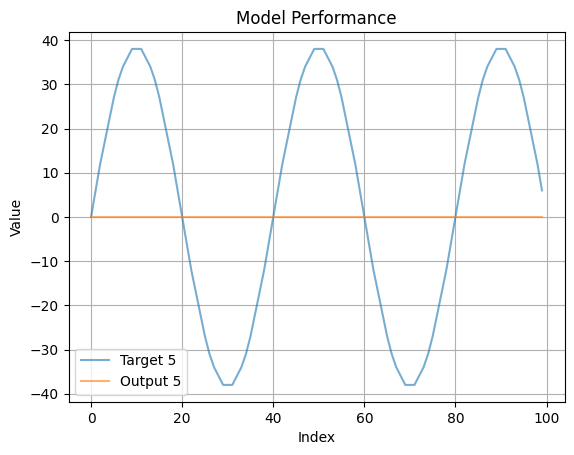

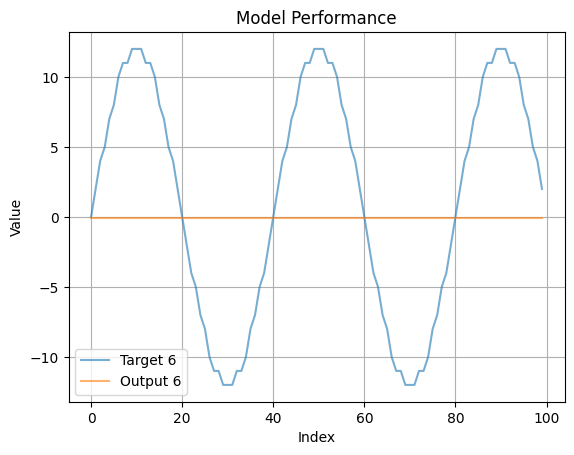

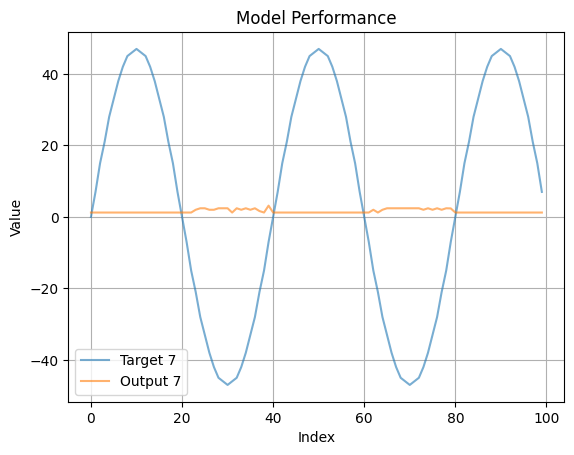

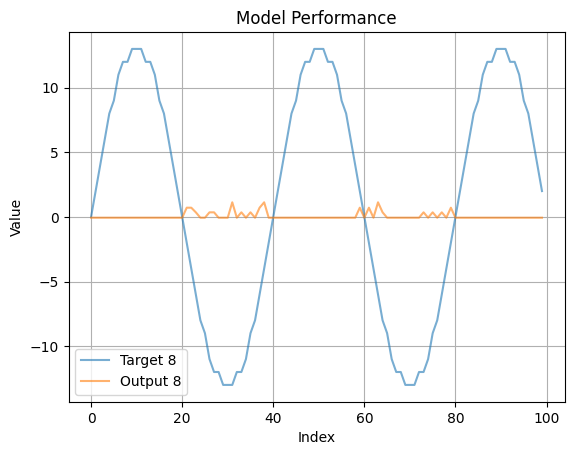

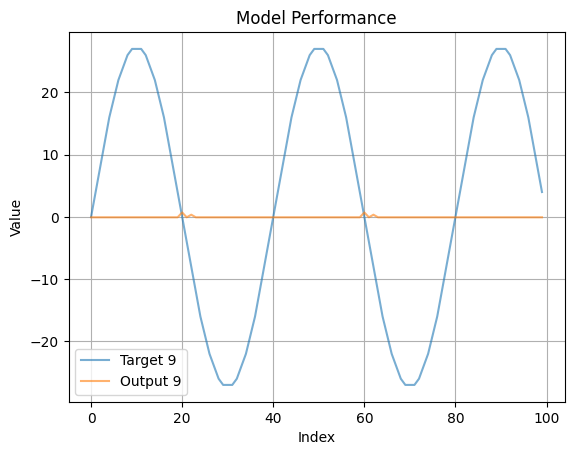

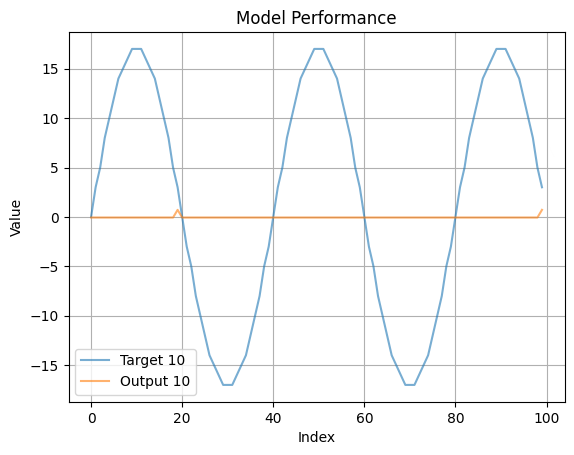

In [ ]:
# rasters for best model of evolution and sine wave predictions
def plot_model_performance(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            outputs, spikes = model(inputs)
            fig, ax = plt.subplots(figsize=(10, 5))
            splt.raster(spikes, ax=ax, c="black")
            ax.set_xlabel("Timestep")
            ax.set_ylabel("Neuron")
            ax.set_title("Spike Raster Plot")
            plt.show()

            for i in range(min(10, len(targets))):  # Visualize up to 10 samples
                target = targets[i].cpu().numpy()
                output = outputs[i].cpu().numpy()

                x_target = np.arange(len(target))
                x_output = np.arange(len(output))

                plt.plot(x_target, target, label=f'Target {i+1}', alpha=0.6)
                plt.plot(x_output, output, label=f'Output {i+1}', alpha=0.6)

                plt.xlabel('Index')
                plt.ylabel('Value')
                plt.title("Model Performance")
                plt.legend()
                plt.grid(True)
                plt.show()

            break  # Only plot for the first batch

plot_model_performance(best_model, dataloader0)